<a href="https://colab.research.google.com/github/Sonica-B/Deep-Learning-CS541_F2024/blob/HomeWork4/homework4(b)_Shreya_Boyane_Ankit_Gole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Check for GPU availability and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data Loading with Transformations
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

train_dataset = datasets.FashionMNIST(root='data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='data', train=False, transform=transforms.ToTensor(), download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Using only the first 1000 examples from the training dataset
small_train_dataset = torch.utils.data.Subset(train_dataset, range(1000))
small_train_loader = DataLoader(small_train_dataset, batch_size=64, shuffle=True)

# Define the FCNN Model
class SimpleFCNN(nn.Module):
    def __init__(self):
        super(SimpleFCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        return self.model(x)

# Initialize model, criterion, and optimizer
model = SimpleFCNN().to(device)
criterion = nn.CrossEntropyLoss()

# Convert model parameters to a single vector
def get_params_vector(model):
    return torch.cat([param.view(-1) for param in model.parameters()])



Using device: cuda


In [6]:
# Training function with tracking
def train_model_with_tracking(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    param_trajectories, loss_values = [], []

    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            param_trajectories.append(get_params_vector(model).cpu().detach().numpy())
            loss_values.append(loss.item())
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

    return param_trajectories, loss_values

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy



In [30]:
# Run the training with two different initializations
def run_experiment(model_class, train_loader, criterion, lr=0.04, epochs=10):
    model = model_class().to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    return train_model_with_tracking(model, train_loader, criterion, optimizer, epochs)

# Get trajectories and losses for both runs
param_trajectories_1, loss_values_1 = run_experiment(SimpleFCNN, small_train_loader, criterion)
param_trajectories_2, loss_values_2 = run_experiment(SimpleFCNN, small_train_loader, criterion)

# Combine and perform PCA on the trajectories
all_trajectories = np.vstack([param_trajectories_1, param_trajectories_2])
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(all_trajectories)

# Split the PCA-transformed data
pca_trajectories_1 = pca_transformed[:len(param_trajectories_1)]
pca_trajectories_2 = pca_transformed[len(param_trajectories_1):]

# Define grid in PCA space for loss landscape
x_min, x_max = pca_transformed[:, 0].min() - 1, pca_transformed[:, 0].max() + 1
y_min, y_max = pca_transformed[:, 1].min() - 1, pca_transformed[:, 1].max() + 1
grid_x, grid_y = np.meshgrid(np.linspace(x_min, x_max, 25), np.linspace(y_min, y_max, 25))
grid_points = np.c_[grid_x.ravel(), grid_y.ravel()]

def load_parameters(model, param_vector):
    start_idx = 0
    with torch.no_grad():  # Ensure no gradients are computed when setting parameters
        for param in model.parameters():
            param_size = param.numel()
            new_values = torch.tensor(param_vector[start_idx:start_idx + param_size]).reshape(param.shape).to(device)
            param.copy_(new_values)
            start_idx += param_size

# Map grid points back to high-dimensional space and compute loss
def compute_loss_landscape(model, grid_points, train_loader):
    grid_loss_values = []
    for param_vector in pca.inverse_transform(grid_points):
        load_parameters(model, param_vector)
        total_loss = sum(criterion(model(images.to(device)), labels.to(device)).item()
                         for images, labels in train_loader)
        grid_loss_values.append(total_loss / len(train_loader))
    return np.array(grid_loss_values).reshape(grid_x.shape)

grid_loss_values = compute_loss_landscape(model, grid_points, small_train_loader)



Epoch [1/10], Loss: 1.7773
Epoch [2/10], Loss: 1.2869
Epoch [3/10], Loss: 1.0859
Epoch [4/10], Loss: 0.9395
Epoch [5/10], Loss: 0.8406
Epoch [6/10], Loss: 0.7565
Epoch [7/10], Loss: 0.7020
Epoch [8/10], Loss: 0.6727
Epoch [9/10], Loss: 0.6123
Epoch [10/10], Loss: 0.5664
Epoch [1/10], Loss: 1.7962
Epoch [2/10], Loss: 1.2971
Epoch [3/10], Loss: 1.0590
Epoch [4/10], Loss: 0.8971
Epoch [5/10], Loss: 0.8378
Epoch [6/10], Loss: 0.7564
Epoch [7/10], Loss: 0.6935
Epoch [8/10], Loss: 0.6398
Epoch [9/10], Loss: 0.6059
Epoch [10/10], Loss: 0.5616


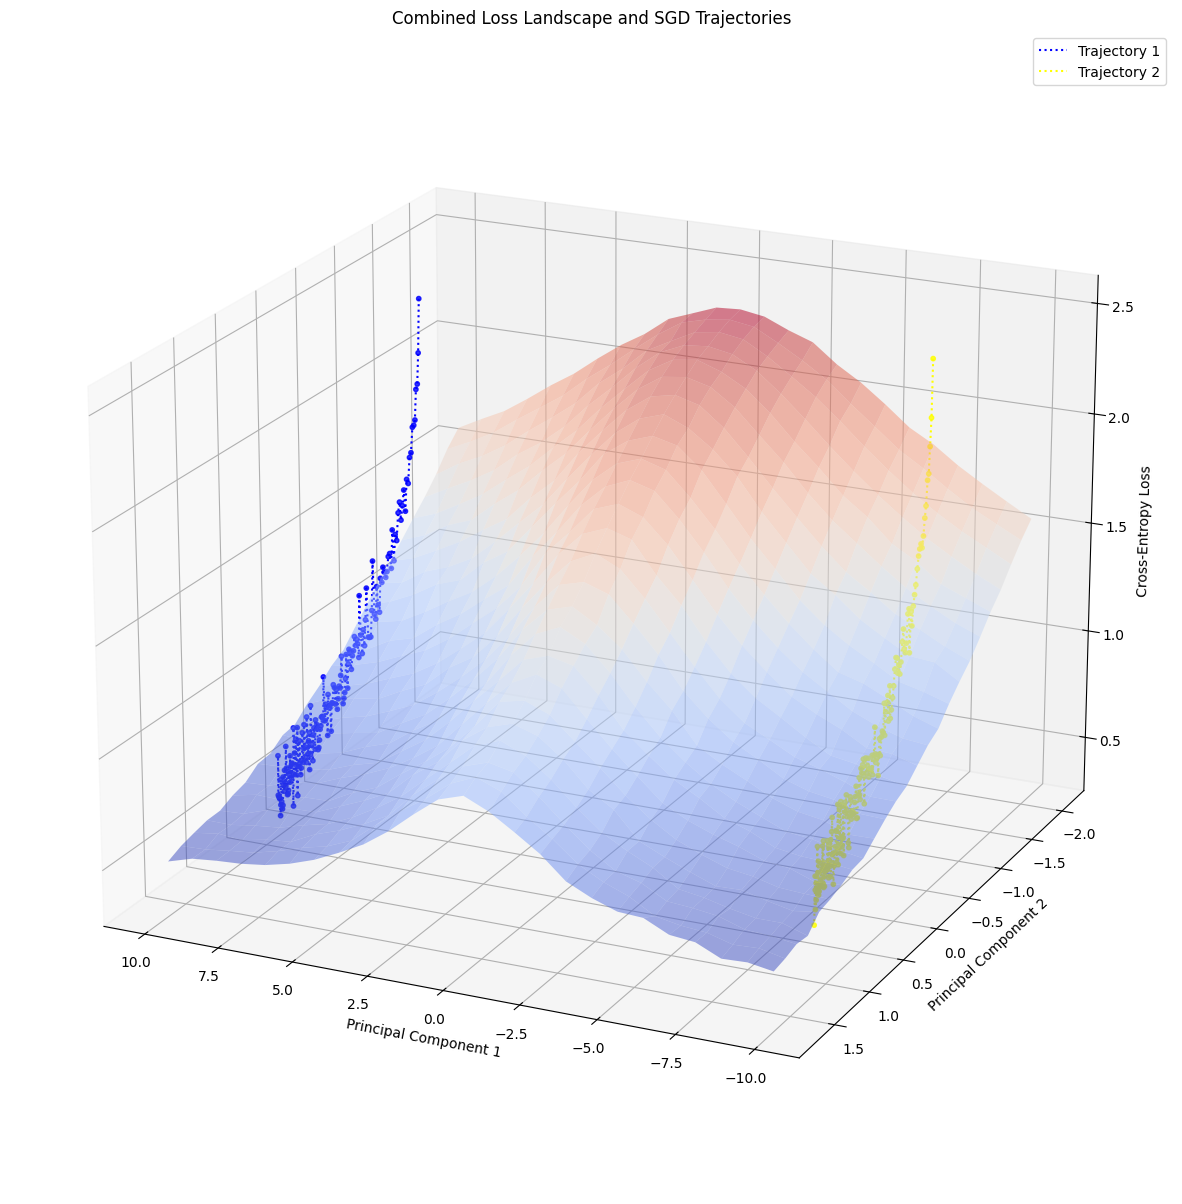

In [38]:
# Plot the 3D loss landscape and trajectories
def plot_loss_landscape(grid_x, grid_y, grid_loss_values, pca_trajectories_1, loss_values_1, pca_trajectories_2, loss_values_2):
    fig = plt.figure(figsize=(15, 20))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(grid_x, grid_y, grid_loss_values, cmap='coolwarm', edgecolor='none', alpha=0.5)

    # Plot trajectories
    for pca_traj, loss_vals, color, label in zip(
        [pca_trajectories_1, pca_trajectories_2], [loss_values_1, loss_values_2], ['blue', 'yellow'], ['Trajectory 1', 'Trajectory 2']
    ):
        ax.plot(pca_traj[:, 0], pca_traj[:, 1], loss_vals, color=color, linestyle='dotted', label=label)
        ax.scatter(pca_traj[:, 0], pca_traj[:, 1], loss_vals, color=color, alpha=0.8, s=10)

# ax.scatter(trajectory1_pca[:, 0], trajectory1_pca[:, 1], losses1, c='blue', s=10, label='Trajectory 1')
# ax.scatter(trajectory2_pca[:, 0], trajectory2_pca[:, 1], losses2, c='yellow', s=10, label='Trajectory 2')

    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.set_zlabel("Cross-Entropy Loss")
    ax.set_title("Combined Loss Landscape and SGD Trajectories")
    ax.legend()
    ax.view_init(elev=20, azim=115)
    plt.show()

plot_loss_landscape(grid_x, grid_y, grid_loss_values, pca_trajectories_1, loss_values_1, pca_trajectories_2, loss_values_2)
